In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import feyn

import emcee
import corner

from catwoman import catwoman

import ksz
import ksz.Pee as Pee

from ksz.parameters import modelparams_Gorce2022

This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

##### sims

In [3]:
#df = pd.read_csv('/Users/emcbride/catwoman/scripts/Loreli_data.db')
df = pd.read_csv('/Users/emcbride/kSZ/data/LoreLi_summaries/Loreli_data.db')
df.set_index('sim_n', inplace=True)
df.index = df.index.astype(str)
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
path = '/Users/emcbride/kSZ/data/LoreLi_summaries'

sims_dict = {}

for file in os.listdir(f'{path}/lklhd_files/'):
    lklhd = np.load(f'{path}/lklhd_files/{file}')
    basename, extension = os.path.splitext(file)
    sim_type, sim_n = basename.split('u')

    xe_file = np.load(f'{path}/xe_files/xe_history_simu{sim_n}.npz', allow_pickle=True)
    spectra_file = np.load(f'{path}/spectra_files/spectra_simu{sim_n}.npz', allow_pickle=True)

    simn_dict = {}
    simn_dict['z'] = xe_file['z']
    simn_dict['xe'] = xe_file['xe']
    simn_dict['Pee'] = spectra_file['Pee']
    simn_dict['Pbb'] = spectra_file['Pbb']
    simn_dict['lklhd'] = lklhd

    sims_dict[sim_n] = simn_dict

print(f'Loaded {len(sims_dict)} simulations...')

Loaded 346 simulations...


In [4]:
sim10842 = catwoman.Cat('10842',
                    verbose=False,
                    load_params=True,
                    load_xion=True,
                    load_density=True,
                    initialise_spectra=True,
                    path_sim='/Users/emcbride/kSZ/data/LoReLi')
                  #  path_Pee=f'/loreli/rmeriot/ps_ee/simu{sn}/postprocessing/cubes/ps_dtb')

Loading sim number 10842...

Loaded and ready for science!!



### astro params

In [5]:
astro_labels = ['Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post']

astro_labels_formatted = [
 'Xray \n Lfunc',
 'hard \n Xray \n fraction',
 'gas \n conversion \n timescale',
 'log10_Mmin',                  
 'ion \n escapefrac \n post']

In [6]:
df.loc['10842', astro_labels].to_dict()

{'Xray_Lfunc': 0.0089088,
 'hard_Xray_fraction': 0.4,
 'gasconversion_timescale': 1918.7,
 'log10_Mmin': 8.8,
 'ion_escapefrac_post': 0.275}

### Format Dataset

In [13]:
max_xe = []
for n in sims_dict:
    sim = sims_dict[n]

    max_xe.append(sim['xe'].max())

In [7]:
df_sym = pd.DataFrame(columns=['Pee', 'xe', 'k', 'Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post'])

df_sym_wPbb = pd.DataFrame(columns=['Pee', 'xe', 'k', 'Pbb', 'Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post'])

k_res = ((2 * np.pi) / 300, (2 * np.pi * 256) / 300 / 2)
k_range = np.where((sim10842.k > k_res[0]) & (sim10842.k < k_res[1]))

count = 0
for n in sims_dict:
    print(f'on {count}...')
    sim = sims_dict[n]
    sim_astro = df.loc[n, astro_labels]
    astro_dict = sim_astro.to_dict()
    
    z0 = ksz.utils.find_index(sim['xe'])
    zf = np.where(sim['xe'] < .75)[0][-1]

    z = sim['z'][z0:zf]
    xe = sim['xe'][z0:zf]
    k = sim10842.k[k_range]
    Pee = ksz.utils.unpack_data(sim['Pee'], 'P_k', (z0, zf), (k_range[0][0], k_range[0][-1]+1))
    Pbb = ksz.utils.unpack_data(sim['Pbb'], 'P_k', (z0, zf), (k_range[0][0], k_range[0][-1]+1))

    for i, xe_i in enumerate(xe):
        for j, k_j in enumerate(k):
            Pee_obs = {'Pee': Pee[i,j], 'xe': xe_i, 'k': k_j}
            Pee_obs.update(astro_dict)

            Pee_obs_Pbb = {'Pee': Pee[i,j], 'xe': xe_i, 'k': k_j, 'Pbb': Pbb[i,j]}
            Pee_obs_Pbb.update(astro_dict)
            
            df_sym = pd.concat([df_sym, pd.DataFrame(Pee_obs, index=[0])], ignore_index=True)
            df_sym_wPbb = pd.concat([df_sym_wPbb, pd.DataFrame(Pee_obs_Pbb, index=[0])], ignore_index=True)
            
    count += 1

on 0...


/var/folders/8t/k878xr_j2fqgy_993tg3qy7c0000gn/T/ipykernel_53678/423764483.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sym = pd.concat([df_sym, pd.DataFrame(Pee_obs, index=[0])], ignore_index=True)
/var/folders/8t/k878xr_j2fqgy_993tg3qy7c0000gn/T/ipykernel_53678/423764483.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sym_wPbb = pd.concat([df_sym_wPbb, pd.DataFrame(Pee_obs_Pbb, index=[0])], ignore_index=True)


on 1...
on 2...
on 3...
on 4...
on 5...
on 6...
on 7...
on 8...
on 9...
on 10...
on 11...
on 12...
on 13...
on 14...
on 15...
on 16...
on 17...
on 18...
on 19...
on 20...
on 21...
on 22...
on 23...
on 24...
on 25...
on 26...
on 27...
on 28...
on 29...
on 30...
on 31...
on 32...
on 33...
on 34...
on 35...
on 36...
on 37...
on 38...
on 39...
on 40...
on 41...
on 42...
on 43...
on 44...
on 45...
on 46...
on 47...
on 48...
on 49...
on 50...
on 51...
on 52...
on 53...
on 54...
on 55...
on 56...
on 57...
on 58...
on 59...
on 60...
on 61...
on 62...
on 63...
on 64...
on 65...
on 66...
on 67...
on 68...
on 69...
on 70...
on 71...
on 72...
on 73...
on 74...
on 75...
on 76...
on 77...
on 78...
on 79...
on 80...
on 81...
on 82...
on 83...
on 84...
on 85...
on 86...
on 87...
on 88...
on 89...
on 90...
on 91...
on 92...
on 93...
on 94...
on 95...
on 96...
on 97...
on 98...
on 99...
on 100...
on 101...
on 102...
on 103...
on 104...
on 105...
on 106...
on 107...
on 108...
on 109...
on 110...
on 111..

In [9]:
import pickle

# Load the dictionary from a pickle file
with open('a0.pkl', 'rb') as f:
    a0s = pickle.load(f)

with open('kappa.pkl', 'rb') as f:
    kappas = pickle.load(f)
    
with open('a0_errs.pkl', 'rb') as f:
    a0_errs = pickle.load(f)

with open('kappa_errs.pkl', 'rb') as f:
    kappa_errs = pickle.load(f)

with open('excluded_sims.pkl', 'rb') as f:
    exclude = pickle.load(f)

In [13]:
if '10038' not in exclude:
    print('hi!')

hi!


In [14]:
# format for params

df_a0 = pd.DataFrame(columns=['a0', 'Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post'])

df_kappa = pd.DataFrame(columns=['kappa', 'Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post'])

k_res = ((2 * np.pi) / 300, (2 * np.pi * 256) / 300 / 2)
k_range = np.where((sim10842.k > k_res[0]) & (sim10842.k < k_res[1]))

k0 = k_range[0][0]
kf = k_range[0][-1]

a0_weights = []
kappa_weights = []

count = 0
for n in sims_dict:
    print(f'on {count}...')

    if n in exclude:
        print(f'skipping {n}...')

    else:
        sim = sims_dict[n]
        sim_astro = df.loc[n, astro_labels]
        astro_dict_a0 = sim_astro.to_dict()
        astro_dict_kappa = sim_astro.to_dict()
    
        a0 = a0s[n]
        kappa = kappas[n]
        a0_weights.append(a0_errs[n])
        kappa_weights.append(kappa_errs[n])
    
        astro_dict_a0['a0'] = a0
        astro_dict_kappa['kappa'] = kappa
    
        df_a0 = pd.concat([df_a0, pd.DataFrame(astro_dict_a0, index=[0])], ignore_index=True)
        df_kappa = pd.concat([df_kappa, pd.DataFrame(astro_dict_kappa, index=[0])], ignore_index=True)    
            
    count += 1

on 0...
skipping 13594...
on 1...
on 2...
on 3...
on 4...
on 5...
on 6...
on 7...
on 8...
on 9...
on 10...
on 11...
on 12...
on 13...
on 14...
on 15...
on 16...
skipping 13595...
on 17...
on 18...
skipping 13597...
on 19...
on 20...
on 21...
on 22...
on 23...
on 24...
on 25...
on 26...
on 27...
skipping 13596...
on 28...
skipping 13592...
on 29...
skipping 13586...
on 30...
on 31...
on 32...
on 33...
on 34...
on 35...
on 36...
on 37...
on 38...
on 39...
on 40...
on 41...
on 42...
on 43...
on 44...
on 45...
on 46...
on 47...
skipping 13587...
on 48...
skipping 13593...
on 49...
skipping 13585...
on 50...
skipping 13591...
on 51...
on 52...
on 53...
on 54...
on 55...
on 56...
on 57...
on 58...
on 59...
on 60...
on 61...
on 62...
skipping 13590...
on 63...
skipping 13584...
on 64...
on 65...
on 66...
on 67...
on 68...
on 69...
on 70...
on 71...
on 72...
on 73...
on 74...
on 75...
on 76...
on 77...
on 78...
on 79...
on 80...
on 81...
on 82...
on 83...
on 84...
on 85...
on 86...
on 87...
on

/var/folders/8t/k878xr_j2fqgy_993tg3qy7c0000gn/T/ipykernel_53678/1946430351.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_a0 = pd.concat([df_a0, pd.DataFrame(astro_dict_a0, index=[0])], ignore_index=True)
/var/folders/8t/k878xr_j2fqgy_993tg3qy7c0000gn/T/ipykernel_53678/1946430351.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_kappa = pd.concat([df_kappa, pd.DataFrame(astro_dict_kappa, index=[0])], ignore_index=True)


In [18]:
df_a0.Xray_Lfunc.value_counts()

Xray_Lfunc
0.000288    43
0.001920    39
0.008909    36
0.001306    36
0.006067    35
0.002822    27
0.000422    24
0.004128    22
0.000192    21
0.000614    20
0.000883    18
0.013075    14
0.019200    11
Name: count, dtype: int64

In [20]:
#df_k = pd.DataFrame(arr, columns=[f'k{i+1}' for i in range(arr.shape[1])])
#df_xe = pd.DataFrame(arr, columns=[f'xe{i+1}' for i in range(arr.shape[1])])

In [58]:
for col in df_kappa.columns:
    print(f"Column '{col}':")
    print(df_kappa[col].value_counts())
    print("-" * 30)

Column 'kappa':
kappa
0.047640    20
0.044137    17
0.043786    13
0.044487    13
0.046939    12
            ..
0.055696     1
0.059900     1
0.075663     1
0.083720     1
0.216831     1
Name: count, Length: 100, dtype: int64
------------------------------
Column 'Xray_Lfunc':
Xray_Lfunc
0.000288    43
0.001920    39
0.008909    36
0.001306    36
0.006067    35
0.002822    27
0.000422    24
0.004128    22
0.000192    21
0.000614    20
0.000883    18
0.013075    14
0.019200    11
Name: count, dtype: int64
------------------------------
Column 'hard_Xray_fraction':
hard_Xray_fraction
0.4    133
0.0     43
0.6     43
0.2     43
1.0     42
0.8     42
Name: count, dtype: int64
------------------------------
Column 'gasconversion_timescale':
gasconversion_timescale
3241.5     72
2527.8     48
10504.7    48
1215.1     39
3197.9     25
1998.1     24
4045.7      9
6475.2      5
3937.8      5
1918.7      5
1516.6      5
3884.9      5
1971.2      5
2427.3      5
3070.8      5
2493.8      5
5049.6

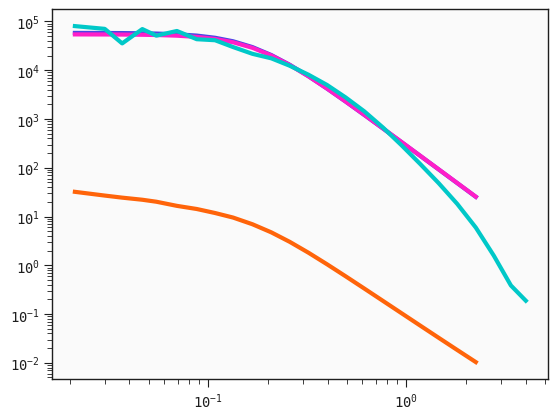

In [166]:
plt.loglog(k, model.calc_spectra(params_run)[20])
plt.loglog(k, model.calc_spectra(params_single)[20])

plt.loglog(sims_dict['10842']['Pee'][i]['k'], sims_dict['10842']['Pee'][20]['P_k'])

plt.loglog(k, check[1])

In [29]:
large_kappa = ['13586', '13585', '13587', '13584', '10842', '10038']

on sim 13586
all xe
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.001 0.001 0.001 0.001 0.002 0.002 0.003 0.003 0.004 0.005 0.006
 0.007 0.009 0.01  0.012 0.015 0.018 0.022 0.027 0.032 0.039 0.047 0.055
 0.066 0.077 0.09  0.104 0.12  0.138 0.157 0.177 0.2   0.224 0.25  0.277
 0.306 0.338 0.371 0.406 0.444 0.484 0.526 0.57  0.616 0.665 0.714 0.763
 0.811 0.856 0.895 0.927 0.951 0.97 ]
zrange (26, 64)  and size  38
trunc xe
[0.01  0.012 0.015 0.018 0.022 0.027 0.032 0.039 0.047 0.055 0.066 0.077
 0.09  0.104 0.12  0.138 0.157 0.177 0.2   0.224 0.25  0.277 0.306 0.338
 0.371 0.406 0.444 0.484 0.526 0.57  0.616 0.665 0.714 0.763 0.811 0.856
 0.895 0.927]
Gorce 2022 Pee spectrum is now initialised!

model params are  {'alpha_0': 224.65133772041335, 'kappa': 0.30580483736447045, 'a_xe': -0.2, 'k_xe': 1.0, 'k_f': 9.4, 'g': 0.5}
on sim 13585
all xe
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.001 0.001 0.001 0.001 0.002 0.002 0.003 0

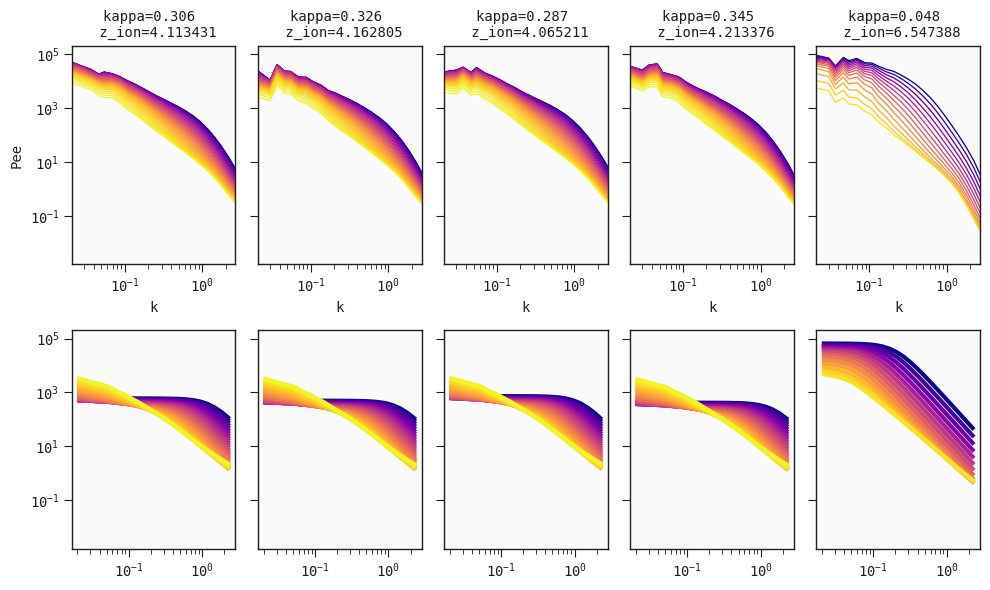

In [30]:

k0 = 3
kf = 18

import copy as cp

check = []
np.set_printoptions(precision=3, suppress=True)

fig, axes = plt.subplots(2,5, figsize=(10,6), sharey=True)
from matplotlib.colors import Normalize


ax = axes[0,:]

for j, lk in enumerate(large_kappa[:-1]):
    print('on sim', lk)
    params = cp.deepcopy(modelparams_Gorce2022)
    params['alpha_0'] = 10**a0s[lk]
    params['kappa'] = kappas[lk]

    z = sims_dict[lk]['z']
    xe = sims_dict[lk]['xe']

    print('all xe')
    print(xe)
    
    z0 = np.where(xe > .01)[0][0]
    zf = np.where(xe > .9)[0][0] + 1
    zrange = (z0, zf)
    print(f'zrange', zrange, ' and size ', zf-z0)

    norm = Normalize(vmin=z[zf], vmax=z[z0])

    print('trunc xe')
    print(xe[z0:zf])

    model = ksz.Pee.Gorce2022(k, z, xe,
                              model_params=params, verbose=False)

    print('model params are ', model.model_params)
    for i in range(z0,zf):
        axes[1,j].loglog(k, model.spectra[i], color=plt.get_cmap('plasma_r')(norm(z[i])))
        if lk == '10842':
            check.append(model.spectra[i])
        
    for i in range(z0,zf):
        ax[j].loglog(sims_dict[lk]['Pee'][i]['k'], sims_dict[lk]['Pee'][i]['P_k'],
                     lw=.95, color=plt.get_cmap('plasma_r')(norm(z[i])))

    ax[j].set_title(f'kappa={kappas[lk]:.3f} \n z_ion={sims_dict[lk]['z'][np.where(sims_dict[lk]['xe'] > 0.9)[0][0]]}', fontsize=10)
    ax[j].set_xlabel('k')
    ax[j].set_xlim(k_res)

ax[0].set_ylabel('Pee')
    
fig.tight_layout()

on sim 13586
zrange (26, 64)  and size  38
Gorce 2022 Pee spectrum is now initialised!

on sim 13585
zrange (25, 63)  and size  38
Gorce 2022 Pee spectrum is now initialised!

on sim 13587
zrange (28, 65)  and size  37
Gorce 2022 Pee spectrum is now initialised!

on sim 13584
zrange (24, 62)  and size  38
Gorce 2022 Pee spectrum is now initialised!

on sim 10842
zrange (19, 33)  and size  14
Gorce 2022 Pee spectrum is now initialised!

on sim 10038
zrange (28, 47)  and size  19
Gorce 2022 Pee spectrum is now initialised!



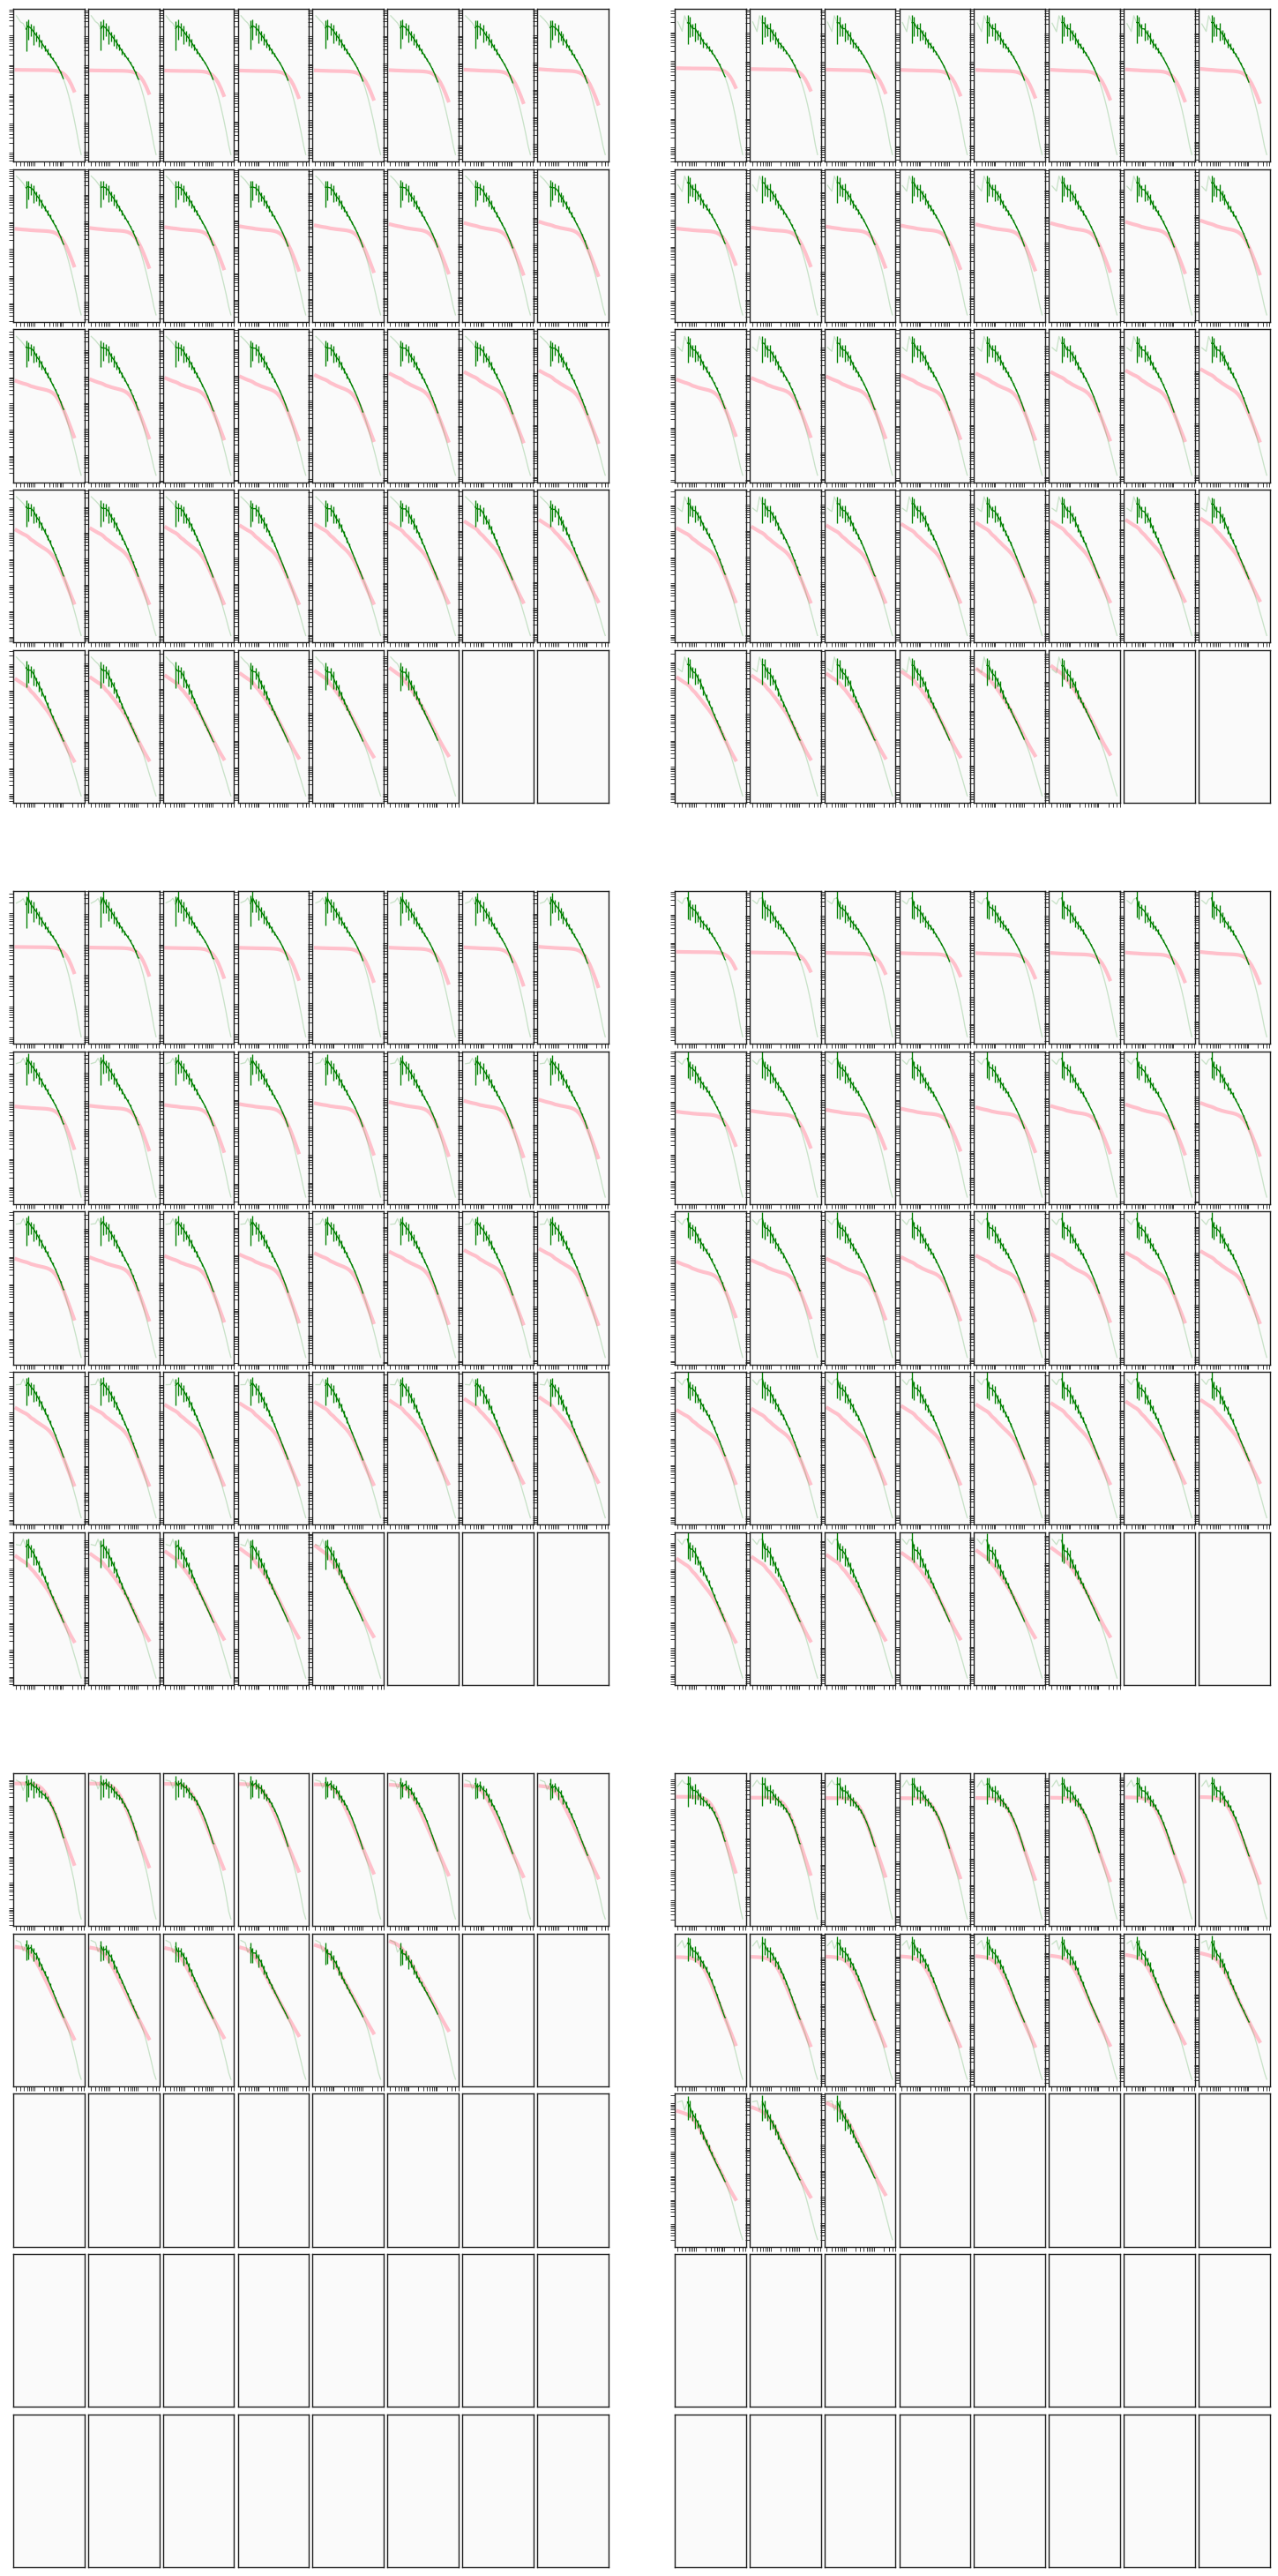

In [193]:
from scipy.interpolate import CubicSpline, RectBivariateSpline

errs_fn = '/Users/emcbride/kSZ/data/EMMA/EMMA_frac_errs.npz'
errs = np.load(errs_fn)
EMMA_k = errs['k']
frac_err_EMMA = errs['err']
err_spline  = CubicSpline(EMMA_k, frac_err_EMMA)

# Create the main figure
fig = plt.figure(figsize=(15,30))

# Create a 2x2 grid of subfigures
subfigs = fig.subfigures(3, 2)

# Loop over each subfigure
for j, subfig in enumerate(subfigs.flat):
    lk = large_kappa[j]
    print('on sim', lk)
    
    params = cp.deepcopy(modelparams_Gorce2022)
    params['alpha_0'] = 10**a0s[lk]
    params['kappa'] = kappas[lk]

    z = sims_dict[lk]['z']
    xe = sims_dict[lk]['xe']

    z0 = np.where(xe > .01)[0][0]
    zf = np.where(xe > .9)[0][0] + 1
    zrange = (z0, zf)
    print(f'zrange', zrange, ' and size ', zf-z0)

    model = ksz.Pee.Gorce2022(k, z, xe,
                              model_params=params, verbose=False)
    
    # Create a 4x4 grid of subplots in each subfigure
    axs = subfig.subplots(5, 8)
    
    # Flatten the grid of axes for easy iteration
    axs = axs.flatten()
    
    for ind, i in enumerate(range(z0,zf)):
        axs[ind].loglog(k, model.spectra[i], color='pink')
        if lk == '10842':
            check.append(model.spectra[i])
        
    for ind, i in enumerate(range(z0,zf)):
        axs[ind].loglog(sims_dict[lk]['Pee'][i]['k'], sims_dict[lk]['Pee'][i]['P_k'],
                     lw=.95, color='green', alpha=.2)
        axs[ind].errorbar(sims_dict[lk]['Pee'][i]['k'][k0:kf], sims_dict[lk]['Pee'][i]['P_k'][k0:kf],
                     lw=.95, color='green',
                          yerr=sims_dict[lk]['Pee'][i]['P_k'][k0:kf] * err_spline(sims_dict[lk]['Pee'][i]['k'][k0:kf]))

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Remove space between subplots in each subfigure
    subfig.subplots_adjust(wspace=0, hspace=0)

# Adjust layout of the entire figure to remove space between subfigures
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05, hspace=0.05)




### Symbolic Regression

### Astro params

In [15]:
ql = feyn.QLattice()

##### astro to Pee

In [16]:
function_names = ['squared', 'inverse', 'linear', 'add', 'multiply']

In [24]:
models_regression = ql.sample_models(['xe', 'k', 'Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post'], output_name='Pee', kind="regression")
models_regression = feyn.fit_models(models_regression, df_sym)

In [26]:
models = ql.auto_run(df_sym, output_name="Pee",
                                        max_complexity=10, n_epochs=1000,
                                        function_names=function_names)

In [ ]:
models

##### astro to G22

In [17]:
function_names = ['squared', 'inverse', 'linear', 'add', 'multiply']#, 'log']

models_a0 = ql.auto_run(df_a0, output_name="a0",
                                        max_complexity=7, n_epochs=1500,
                                        function_names=function_names)

In [18]:
models_a0_weights = ql.auto_run(df_a0, output_name="a0",
                                        max_complexity=7, n_epochs=1500,
                                        function_names=function_names, sample_weights=a0_weights)

In [19]:
# new dataset
models_a0[0].sympify()

-8.23986e-5*gasconversiontimescale - 0.279286*(3.87524 - 0.351021*log10Mmin)*(133.941*XrayLfunc - 12.1445*ionescapefracpost + 4.33168) + 4.96154

In [20]:
# new dataset
models_a0_weights[0].sympify()

0.402527*(1.086*hardXrayfraction + 1.12088)*(-32.7998*XrayLfunc + (2.3115 - 3.20991*ionescapefracpost)*(-0.000136391*gasconversiontimescale - 0.745316) + 1.90249) + 4.35416

In [29]:
models_a0[0].sympify()

5.95353 + 4.5089/(0.000195152*gasconversiontimescale + (0.243174 - 5.85388*ionescapefracpost)*(1.27475 - 29.6924*XrayLfunc) - 1.99199)

In [32]:
models_a0_weights[0].sympify()

1.40324*(-0.000123771*gasconversiontimescale - 0.719708)*(14.7492*XrayLfunc - 0.30592 + 1/(2.4987*ionescapefracpost + 0.373283)) + 5.50213

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="248.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 875 248.0" width="875" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="50.0"><title>a0
linear:
scale=1.489977
scale offset=0.000000
w=0.270156
bias=2.9223</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">a0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="59.0">linear</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="20.0"><title>hard_Xray_fraction
linear:
scale=2.000000
scale offset=0.469565
w=0.543001
bias=1.6308</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">hard_Xra..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">3</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>Xray_Lfunc
linear:
scale=105.218855
scale offset=0.003688
w=-0.311729
bias=1.7815</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">Xray_Lfunc</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>gasconvers
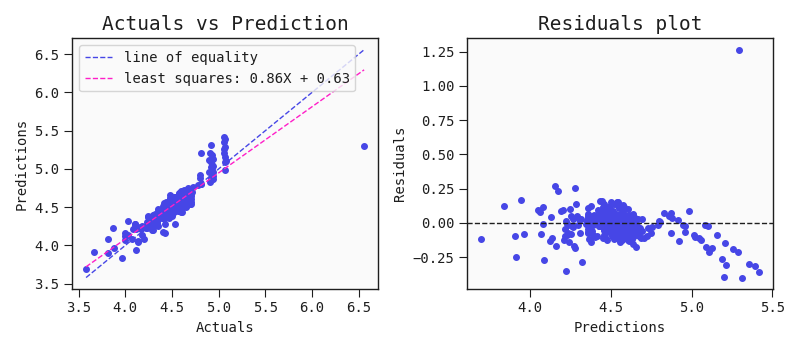
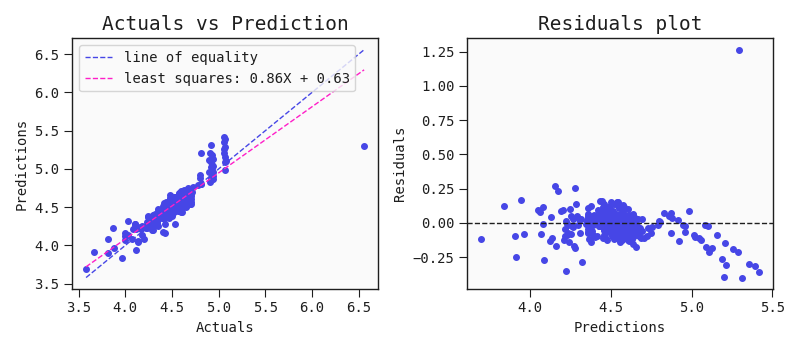

In [21]:
# new dataset w/ weights
models_a0_weights[0].plot(data=df_a0, compare_data=df_a0)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 875 232.0" width="875" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="50.0"><title>a0
linear:
scale=2.183333
scale offset=0.000000
w=0.642704
bias=2.5201</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">a0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="59.0">linear</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="20.0"><title>gasconversion_timescale
linear:
scale=0.000209
scale offset=3906.204624
w=-0.591447
bias=-1.2032</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">gasconve..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">3</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>inverse</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">inverse</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">4</text><line stroke="#1E1E1E" x1="91" x2="121" y1="67.5" y2="37.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="50.0"><title>ion_escapefrac_post
linear:
scale=4.444444
scale offset=0.315968
w=0.562208
bias=1.1628</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="71.5">ion_esca..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="59.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="59.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>Xray_Lfunc
linear:
scale=105.218855
scale offset=0.003673
w=0.14
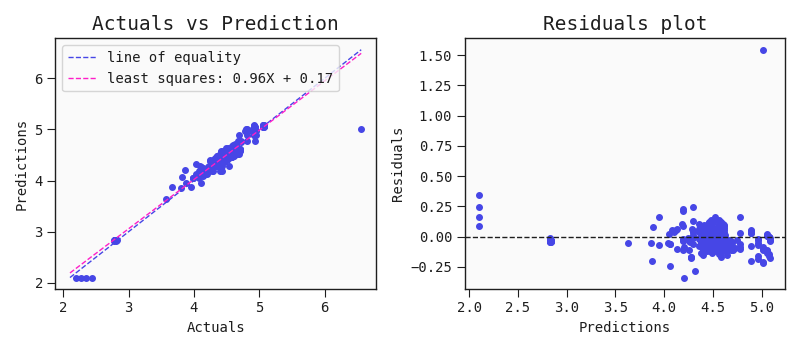
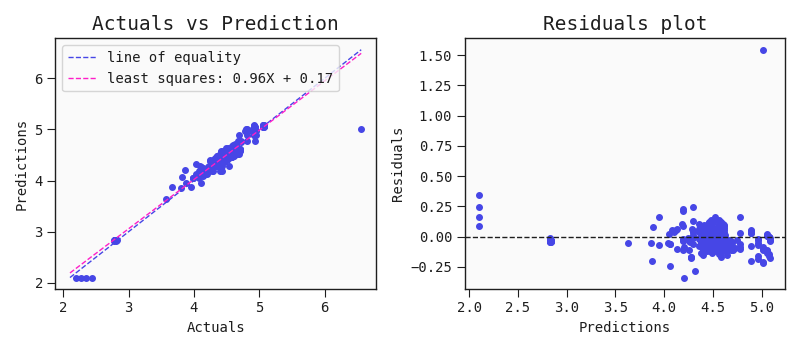

In [34]:
models_a0_weights[0].plot(data=df_a0, compare_data=df_a0)

$$
a_0 = 1.26156
$$

$$
b_1 = 3.19296 \times 10^{-5}
$$

$$
b_2 = 0.215014
$$

$$
c_1 = 0.349982
$$

$$
c_2 = 29.4761
$$

$$
c_3 = 0.479682
$$

$$
d_1 = 38.3833
$$

$$
d_2 = .000593997
$$

$$
g_1 = 1.70807
$$

$$
g_2 = 2.16569
$$

$$
a_2 = 3.56443
$$

$$
a_3 = 5.15278
$$

$a_0 (- b_1 \tau - b_2) \left[- c_1 M_{\text{min}} + c_2 (c_3 - f_{\text{esc}})^2 + (-d_1 L_{\text{Xray}} - d_2)(g_1  f_{\text{Xray}} - g_2) + a_2 \right] + a_3$

$$a_0 (- b_1 \tau - b_2) \left[- c_1 M_{\text{min}} + c_2 (c_3^2 - 2 c_3 f_{\text{esc}} + f_{\text{esc}}^2) + (-d_1 L_{\text{Xray}} g_1 f_{\text{Xray}} - d_2 g_1 f_{\text{Xray}} + d_2 g_2 + d_1 L_{\text{Xray}} g_2) + a_2 \right] + a_3$$
$$a_0 (- b_1 \tau  - b_2) \left[- c_1 M_{\text{min}} + c_2 c_3^2 - 2 c_2  c_3 f_{\text{esc}} + c_2 f_{\text{esc}}^2 -d_1 L_{\text{Xray}} g_1 f_{\text{Xray}} - d_2 g_1 f_{\text{Xray}} + d_2 g_2 + d_1 L_{\text{Xray}} g_2 + a_2 \right] + a_3$$

In [22]:
a_0 = 1.26156
b_1 = 3.19296e-5
b_2 = 0.215014
c_1 = 0.349982
c_2 = 29.4761
c_3 = 0.479682
d_1 = 38.3833
d_2 = .000593997
g_1 = 1.70807
g_2 = 2.16569
a_2 = 3.56443
a_3 = 5.15278

In [72]:
def alpha_symreg(LX, fX, tau, Mmin, fesc):
    base = np.array([-c_1 * Mmin,
             c_2 * c_3**2,
            -2 * c_2 * c_3 * fesc,
             c_2 * fesc**2,
            -d_1 * LX * g_1 * fX, 
            -d_2 * g_1 * fX,
             d_2 * g_2,
             d_1 * LX * g_2,
             a_2])
    arr1 = -a_0 * b_1 * tau * base
    arr2 = -a_0 * b_2 * base

    arr = np.concatenate([arr1, arr2])
    arr = np.concatenate([arr, np.array([a_3])])

    return arr

In [101]:
data_normed_a0 = []
for row in df_a0.iterrows():
    a0_params = row[1][astro_labels].to_list()
    data_normed_a0.append(alpha_symreg(*a0_params) / row[1].a0)

In [121]:
comps = ['-c_1 * Mmin',
             'c_2 * c_3**2',
             '-2 * c_2 * c_3 * fesc',
            'c_2 * fesc**2',
             '-d_1 * LX * g_1 * fX', 
             '-d_2 * g_1 * fX',
             'd_2 * g_2',
             'd_1 * LX * g_2',
             'a_2', 
        '-c_1 * Mmin',
             'c_2 * c_3**2',
             '-2 * c_2 * c_3 * fesc',
            'c_2 * fesc**2',
             '-d_1 * LX * g_1 * fX', 
             '-d_2 * g_1 * fX',
             'd_2 * g_2',
             'd_1 * LX * g_2',
             'a_2', 'a_3']

for i, c in enumerate(np.asarray(data_normed_a0).mean(axis=0)):
    if i == 9:
        print()
    if i == 18:
        print()
    print(f'Contribution from term: {comps[i]} is {c:.5f}')

Contribution from term: -c_1 * Mmin is 0.11085
Contribution from term: c_2 * c_3**2 is -0.24842
Contribution from term: -2 * c_2 * c_3 * fesc is 0.35158
Contribution from term: c_2 * fesc**2 is -0.14594
Contribution from term: -d_1 * LX * g_1 * fX is 0.00334
Contribution from term: -d_2 * g_1 * fX is 0.00002
Contribution from term: d_2 * g_2 is -0.00005
Contribution from term: d_1 * LX * g_2 is -0.00910
Contribution from term: a_2 is -0.13056

Contribution from term: -c_1 * Mmin is 0.19824
Contribution from term: c_2 * c_3**2 is -0.42740
Contribution from term: -2 * c_2 * c_3 * fesc is 0.53752
Contribution from term: c_2 * fesc**2 is -0.19959
Contribution from term: -d_1 * LX * g_1 * fX is 0.00720
Contribution from term: -d_2 * g_1 * fX is 0.00003
Contribution from term: d_2 * g_2 is -0.00008
Contribution from term: d_1 * LX * g_2 is -0.01965
Contribution from term: a_2 is -0.22462

Contribution from term: a_3 is 1.19709


(2.1921846846846846, 6.558851351351351)

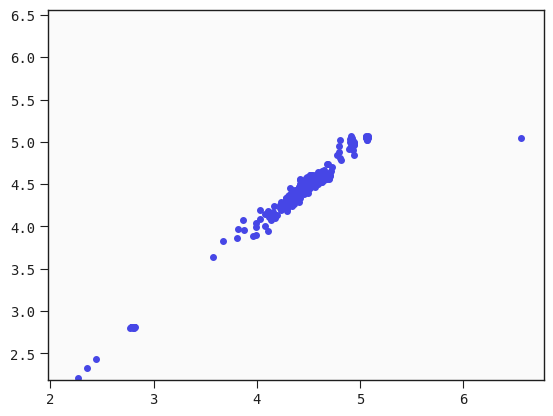

In [74]:
plt.scatter(true, sym)

plt.ylim(min(true), max(true))

In [124]:
models_kappa[0].sympify()

-0.019409*(0.000282948*gasconversiontimescale + 47.4152*(0.402064 - ionescapefracpost)**2 - 0.466606)*(2.74995*ionescapefracpost + (102.18*XrayLfunc - 0.0499602)*(0.393848*hardXrayfraction - 0.659325) - 1.67725) + 0.025794

In [ ]:
a_0 = -0.019409
b_1 = 0.000282948
b_2 = 47.4152
g_1 = 0.402064
b_3 = 0.466606
c_1 = 2.74995
d_1 = 102.18
d_2 = -0.0499602
h_1 = 0.393848
h_2 = -0.659325
b_5 = -1.67725
a_1 = 0.025794

$$-a_0 (b_1 \tau + b_2 (g_1 - f_{\text{esc}}^2) - b_3)(c_1 f_{\text{esc}} + (d_1 L_{\text{Xray}} - d_2)(h_1 f_{\text{Xray}} - h_2) - b_5) + a_1$$

In [ ]:
$$-a_0 (b_1 \tau + b_2 (g_1 - f_{\text{esc}}^2) - b_3)(c_1 f_{\text{esc}} + (d_1 L_{\text{Xray}} - d_2)(h_1 f_{\text{Xray}} - h_2) - b_5) + a_1$$

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="368.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 889 368.0" width="889" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="110.0"><title>kappa
linear:
scale=0.168140
scale offset=0.000000
w=-0.115433
bias=0.1534</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="131.5">kappa</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="119.0">linear</text><line stroke="#1E1E1E" x1="451" x2="481" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="110.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">2</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>squared</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">squared</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="67.5" y2="37.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="50.0"><title>ion_escapefrac_post
linear:
scale=4.444444
scale offset=0.315968
w=-1.549321
bias=0.5928</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="71.5">ion_esca..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="59.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="59.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>gasconversion_timescale
linear:
scale=0.000209
scale offset=3906.204624
w=1.352080
bias=0.6386</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gasconve..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="140.0"><title>add</title></rect><text fill="#1E1E1E" font-
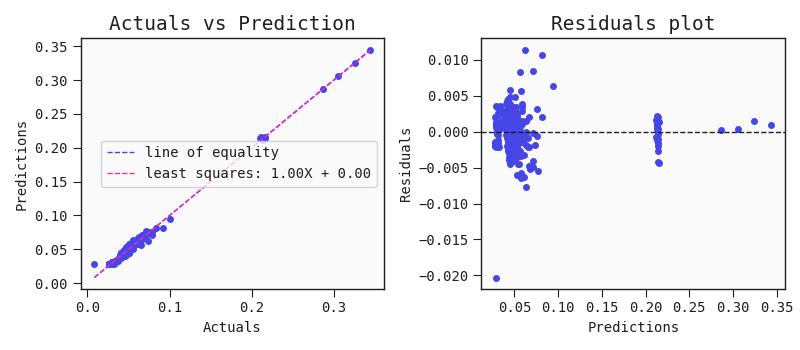
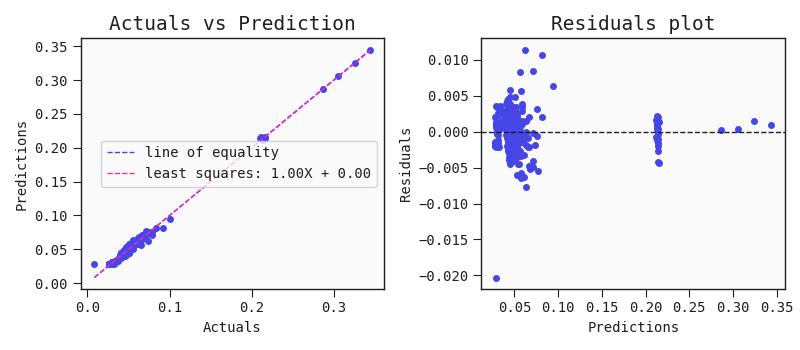

In [123]:
models_kappa[0].plot(data=df_kappa, compare_data=df_kappa)

In [ ]:
models_kappa[0].plot(data=df_kappa, compare_data=df_kappa)

In [63]:
df_a0.gasconversion_timescale.unique() * 1e-5

array([0.031979, 0.024273, 0.081919, 0.019981, 0.039378, 0.105047,
       0.009476, 0.064752, 0.050496, 0.019187, 0.015166, 0.015582,
       0.019712, 0.063883, 0.040457, 0.030708, 0.024938, 0.011988,
       0.032415, 0.024604, 0.025278, 0.012151, 0.039914, 0.049818,
       0.03155 , 0.051183, 0.038849, 0.019448])

In [135]:
models_kappa_complex5[0].sympify()

0.00394637 - 0.112601/(0.000212283*gasconversiontimescale - 8.36192*ionescapefracpost - 0.799964)

In [134]:
models_a0_complex5[0].sympify()

5.67335 - 2.07527/(4.13616*ionescapefracpost + 1.30835*(7.60272e-5*gasconversiontimescale - 1)**2 - 0.228511)

In [22]:
models_kappa = ql.auto_run(df_kappa, output_name="kappa",
                                        max_complexity=7, n_epochs=1500,
                                        function_names=function_names)

In [23]:
models_kappa_weights = ql.auto_run(df_kappa, output_name="kappa",
                                        max_complexity=7, n_epochs=1500,
                                        function_names=function_names, sample_weights=kappa_weights)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="248.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 889 248.0" width="889" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="50.0"><title>kappa
linear:
scale=0.046239
scale offset=0.000000
w=-0.347446
bias=0.4221</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">kappa</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="59.0">linear</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="20.0"><title>gasconversion_timescale
linear:
scale=0.000209
scale offset=3948.465839
w=-0.817877
bias=-1.0073</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">gasconve..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">3</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>ion_escapefrac_post
linear:
scale=8.888889
scale offset=0.335792
w=-0.655195
bias=1.6522</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">ion_esca..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y=
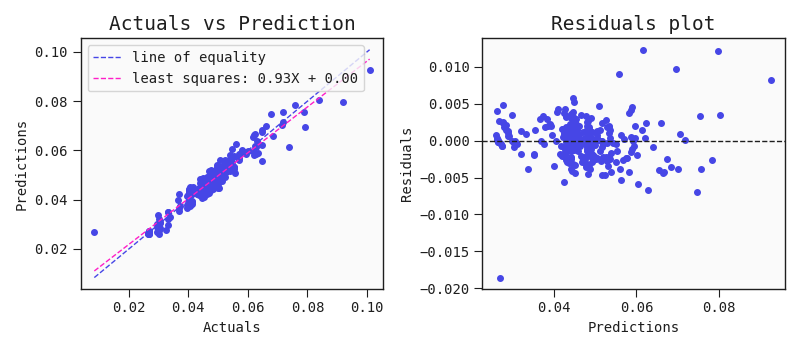
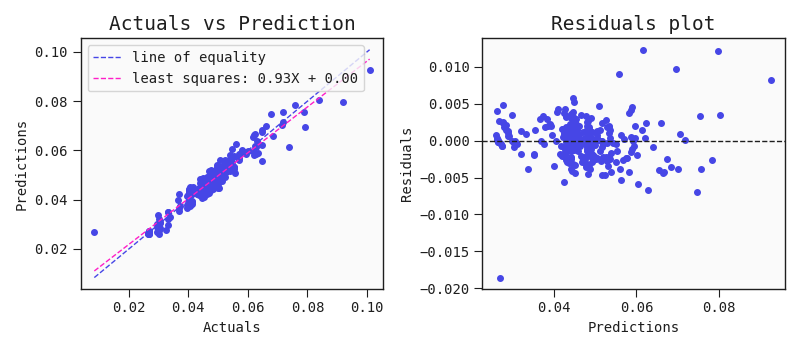

In [24]:
# new model
models_kappa_weights[0].plot(data=df_kappa, compare_data=df_kappa)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 1009 232.0" width="1009" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="711" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="601" y="50.0"><title>kappa
linear:
scale=0.168140
scale offset=0.000000
w=0.299868
bias=0.1376</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="71.5">kappa</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="603" y="59.0">linear</text><line stroke="#1E1E1E" x1="571" x2="601" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="50.0"><title>squared</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">squared</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">1</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">2</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="20.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">3</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="46.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>squared</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">squared</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">4</text><line stroke="#1E1E1E" x1="91" x2="121" y1="67.5" y2="37.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="50.0"><title>ion_escapefrac_post
linear:
scale=4.444444
scale offset=0.315968
w=0.707669
bias=-0.4726</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="71.5">ion_esca..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="59.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="59.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>Xray_Lfunc
linear:
scale=105.218855
scale offset=0.003673
w=0.148849
bias=0.4296</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.
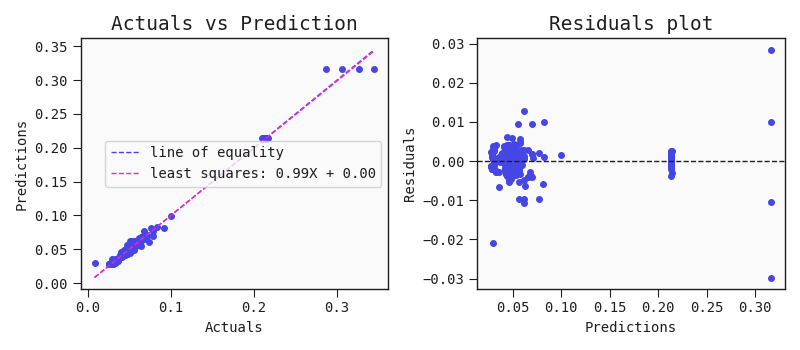
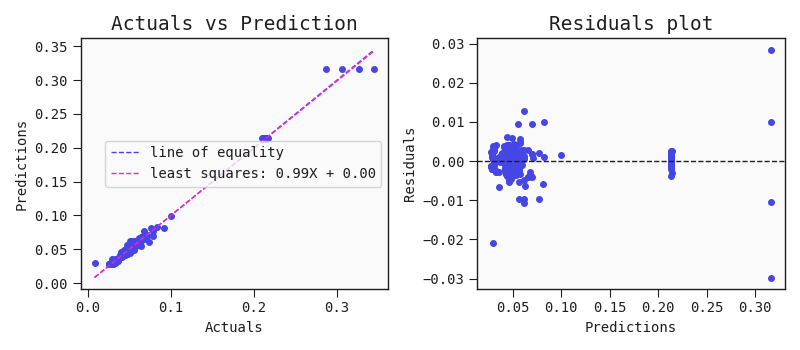

In [41]:
models_kappa_weights[0].plot(data=df_kappa, compare_data=df_kappa)

In [26]:
# new model
models_kappa[0].sympify()

-0.0239519*(0.000182663*gasconversiontimescale + 0.342909)*(3.67286*ionescapefracpost + (0.109852 - 210.138*XrayLfunc)*(0.311574 - 0.22362*hardXrayfraction) - 2.26899) + 0.019932

In [27]:
# new model
models_kappa_weights[0].sympify()

-0.0160654*(-0.000171156*gasconversiontimescale - 0.331464)*(-5.82395*ionescapefracpost + (0.166458 - 334.709*XrayLfunc)*(0.221061*hardXrayfraction - 0.309193) + 3.60781) + 0.0195188

In [44]:
models_kappa[0].sympify()

-0.0997697*(-37.1024*XrayLfunc - 1.2619)*(0.323008*(1.76145 - 0.000113893*gasconversiontimescale)*(7.09907*ionescapefracpost - 0.947997) - 1)**2 + 0.00909732

In [45]:
models_kappa_weights[0].sympify()

4.7879*(-0.000154178*gasconversiontimescale - 1)**2*(XrayLfunc + 0.631621*(ionescapefracpost - 0.466237)**2 + 0.0237568)**2 + 0.0231279

In [62]:
models[2].sympify()

5487830.0*(2.51561 - 2.84377*xe)*exp(-10.4717*(k + 0.645165)**2 - 20502.0*(-0.00734551*ionescapefracpost - xe + 0.0113216)**2) + 1019.06

##### restrained complexity

In [70]:
models_restrained1 = ql.auto_run(df_sym, output_name='Pee', max_complexity=1)

In [74]:
models_restrained1[0].sympify()

20719.4 - 8548.12*k

In [72]:
models_restrained2 = ql.auto_run(df_sym, output_name='Pee', max_complexity=2)

In [75]:
models_restrained2[0].sympify()

-2338.72 - 59471.8/(-22.9233*k - 0.490418)

In [76]:
models_restrained5 = ql.auto_run(df_sym, output_name='Pee', max_complexity=5)


In [77]:
models_restrained5[0].sympify()

4155140.0*exp(-4.27136*(0.44906 - tanh(44.9145*xe - 0.201864))**2 - 12.5314*(k + 0.476656)**2) + 626.729

In [78]:
models_restrained8 = ql.auto_run(df_sym, output_name='Pee', max_complexity=8)

In [79]:
models_restrained8[0].sympify()

5529830.0*(-5.84568*ionescapefracpost - 1.35999)*(3.39937*xe - 3.02464)*exp(-8.00816*(k + 0.844283)**2 - 2.0*exp(-43847.9*(-xe - 0.00205134)**2)) + 3147.73

In [80]:
models_restrained_Pbb = ql.auto_run(df_sym, output_name='Pee', max_complexity=8)

In [81]:
models_restrained_Pbb[0].sympify()

4145310.0*exp(-10.1842*(-k - 0.558981)**2 - 2.0*exp(-6.74384*(4.3093e-5*gasconversiontimescale - 1)**2)*log(70.0168*xe - 0.00280185)**4) + 2795.78

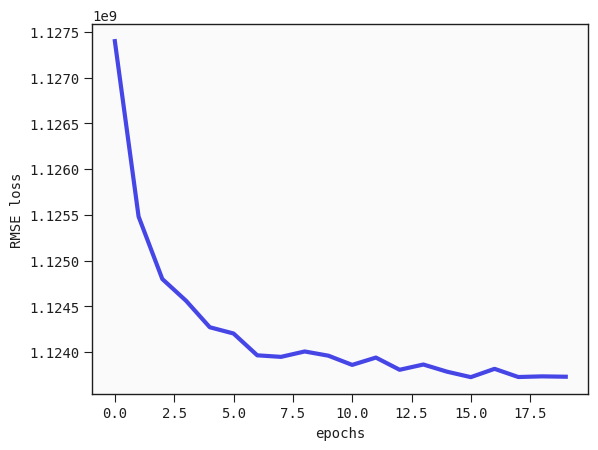

In [63]:
regression_losses = []
epochs = 20
for i in range(epochs):
    models_regression = feyn.fit_models(models_regression, df_sym)
    regression_losses.append(models_regression[0].loss_value)

plt.plot(range(epochs), regression_losses);
plt.xlabel("epochs");
plt.ylabel("RMSE loss");

### Astro params w/ Pbb

In [44]:
ql = feyn.QLattice()

In [45]:
models_regression = ql.sample_models(['xe', 'k', 'Pbb', 'Xray_Lfunc', 'hard_Xray_fraction',
                'gasconversion_timescale', 'log10_Mmin', 'ion_escapefrac_post'], output_name='Pee', kind="regression")
models_regression = feyn.fit_models(models_regression, df_sym_wPbb)

In [46]:
models = ql.auto_run(df_sym, output_name='Pee', max_complexity=10)

In [47]:
models_regression[0].sympify()

38943.6*ionescapefracpost + 300794.0*(0.000570825*Pbb + 0.0192559)*exp(-0.329866*(-0.823475*xe - 1)**4 - 12.5268*(-1.14511e-5*Pbb + 0.0911684*log10Mmin - 1)**2) - 15373.4

In [48]:
models_regression[1].sympify()

-506463.0*(0.000277613*Pbb + 0.008844)*(0.602217*xe - 0.558635) + 1988.92

In [49]:
models_regression[1].sympify()

-506463.0*(0.000277613*Pbb + 0.008844)*(0.602217*xe - 0.558635) + 1988.92

In [50]:
models[0].sympify()

-1982660.0*(0.111096*xe + sqrt(exp(-2.88964*(0.011746*hardXrayfraction + 1)**2 - 20043.1*(-xe - 0.00455872)**2)) - 0.195567)*exp(-15.7884*k) + 2943.98

In [51]:
models[1].sympify()

-560.48 - 1630860.0*(1.9131*xe - 1.73202)*exp(-4.87059*(0.573894*XrayLfunc + 1)**2 - 4.0*exp(-45238.2*(xe + 0.004144)**2))/(4.11021*k + 0.0537931)

In [52]:
models[2].sympify()

-5319210.0*(3.25585*xe - 2.81764)*(2.83866*tanh(tanh(129.444*xe - 0.355409)) + 1.48977)*exp(-9.07455*(-k - 0.789238)**2) + 3225.18

#### Other stuff

In [ ]:
models = ql.auto_run(data_combined, output_name='y')

In [ ]:
models_regression = ql.sample_models(["k"], output_name="P", kind="regression", max_complexity=2)
models_regression = feyn.fit_models(models_regression, data)

len(models_regression)


In [ ]:
regression_losses = []
epochs = 20
for i in range(epochs):
    models_regression = feyn.fit_models(models_regression, data)
    regression_losses.append(models_regression[0].loss_value)

plt.plot(range(epochs), regression_losses);
plt.xlabel("epochs");
plt.ylabel("RMSE loss");


In [ ]:
from feyn.datasets import make_regression

train, test = make_regression()
models = ql.auto_run(train, output_name = 'y')

In [ ]:
best = models[0]
best.plot(train, test)
#best.plot_regression(test)

In [ ]:
best

In [ ]:
import numpy as np
import pandas as pdt

# Example data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = 3 * x**2 + 2 * x + 1 + np.random.normal(0, 10, 100)  # Quadratic relationship with noise

# Convert to a DataFrame
data = pd.DataFrame({'x': x, 'y': y})

# Initialize the QLattice
ql = feyn.QLattice()

model = 'a * x + b'
# Fit the model
models = ql.auto_run(data, 'y', epochs=100, starting_models=[model])

# Select the best model (you can choose based on criteria like accuracy, simplicity, etc.)
best_model = models[0]

# Plot the best model
best_model.plot()

# Print the model equation
print(best_model.get_equation())


In [ ]:
data_combined